In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import comb, perm
from scipy.stats import binom
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D, proj3d

In [2]:
# extract "close" and "far" data frame
proj_df = pd.read_csv("data_proj_414.csv")
close_df = proj_df.loc[proj_df["Close"]>0,["X","Y","Close"]]
far_df = proj_df.loc[proj_df["Far"]>0,["X","Y","Far"]]
frames = [close_df, far_df]
both_df = pd.concat(frames)

# extract data frame of each person
# Potter_df = proj_df.loc[(proj_df["Potter"]>0) & (proj_df["Trip"]<4),["X","Y"]]
# Weasley_df = proj_df.loc[(proj_df["Weasley"]>0)& (proj_df["Trip"]<4),["X","Y"]]
# Granger_df = proj_df.loc[(proj_df["Granger"]>0)& (proj_df["Trip"]<4),["X","Y"]]

# plt.scatter(Potter_df["X"],Potter_df["Y"],color = "tomato",alpha=0.6)
# plt.scatter(Weasley_df["X"],Weasley_df["Y"],color = "dodgerblue",alpha=0.6)
# plt.scatter(Granger_df["X"],Granger_df["Y"],color = "forestgreen",alpha=0.6)

In [3]:
# extract the density of the Tayes
# 1. divide the map into grids
ran_x = 100
ran_y = 100 # since the farest observation of "close" is around 88
grid_size = 1
grid_num = int(ran_x / grid_size)
close_df["Grid_X"] = (close_df["X"]/grid_size).apply(np.ceil)
close_df["Grid_Y"] = (close_df["Y"]/grid_size).apply(np.ceil)
print(close_df)

# Used to calculate the expectation of #Tayes in the intersection area
def intersection(x1, y1, x2, y2, count1, count2):
    r = 1
    dist = math.sqrt(math.pow((x1-x2),2) + math.pow((y1-y2),2))
    if dist == 0: # avoid intersection with self 
        return 0
    if dist > r: # two circles are unoverlapped
        return 0
    area = math.pi
    alpha = math.acos(pow(dist,2)/(2*dist*r))
    area3 = alpha * 2 - math.sin(alpha)*dist # intersection area
    ceil = min(count1,count2)
    if ceil == 0: # there is no observed Tayes in two circles
        return 0
    else:
        p3 = area3 / area # probability of landing in intersection area
        prob = [0]
        px = 0
        for x in range(0,ceil+1):
            prob.append(binom.pmf(k=x, n=count1, p=p3)*binom.pmf(k=x, n=count2, p=p3))
        expectation = 0
        for i in range(1,ceil+1):
            expectation += i * prob[i] # the expected value of Tayes in area3
        expectation /= sum(prob)
        inter_density = expectation / area3
    return inter_density

def density(Grid_X, Grid_Y, close_df):
    grid_df = close_df.loc[(close_df["Grid_X"]==Grid_X) & (close_df["Grid_Y"]==Grid_Y)]
    num = grid_df.shape[0] # number of observation within this grid
    # print(num)
    density = 0
    if num == 0:
        return 0
    elif num == 1:
        density = grid_df["Close"] / math.pi
    elif num > 1:
        for i in range(0,num-1):
            for j in range(i,num):
                x1 = grid_df.iloc[i,0]
                y1 = grid_df.iloc[i,1]
                x2 = grid_df.iloc[j,0]
                y2 = grid_df.iloc[j,1]
                count1 = grid_df.iloc[i,2]
                count2 = grid_df.iloc[j,2]
                density += intersection(x1, y1, x2, y2, count1, count2)
        density /= (math.factorial(num-1)*1.7576)
    return density

print(density(35,46,close_df))
# max(proj_df["Y"])
# max(proj_df["X"])

               X          Y  Close  Grid_X  Grid_Y
26     34.735718  45.908841      1    35.0    46.0
27     36.965981  46.383497      1    37.0    47.0
28     37.310255  46.113536      5    38.0    47.0
29     38.477336  46.087024      4    39.0    47.0
114    46.253579  60.402221      1    47.0    61.0
...          ...        ...    ...     ...     ...
24088  40.269509  73.547902      2    41.0    74.0
24089  40.615083  74.485727      4    41.0    75.0
24090  41.485127  74.335721      1    42.0    75.0
24091  41.275887  76.995216      1    42.0    77.0
24093  40.530502  76.063805      1    41.0    77.0

[2953 rows x 5 columns]
0.030554920885298428


In [4]:
density_data = np.zeros(shape=(10000,3))
density_df = pd.DataFrame(density_data, columns = ["Grid_X", "Grid_Y", "Density"])
for i in range(0,100):
    for j in range(0,100):
        density_df.iloc[i*100+j,0] = i+1
        density_df.iloc[i*100+j,1] = j+1
        
for i in close_df["Grid_X"].unique():
    # update the value of density
    for j in range(1,101):
        density_df.loc[(density_df["Grid_X"]==i) & (density_df["Grid_Y"]==j),["Density"]] = density(i,j,close_df)
densityMap_df = density_df.loc[density_df["Density"]>0]
print(densityMap_df)

      Grid_X  Grid_Y   Density
1512    16.0    13.0  0.269817
1513    16.0    14.0  0.014636
1612    17.0    13.0  0.050916
1613    17.0    14.0  0.496849
1614    17.0    15.0  0.000002
...      ...     ...       ...
7768    78.0    69.0  0.011694
7769    78.0    70.0  0.037009
7968    80.0    69.0  0.041178
8041    81.0    42.0  0.080685
8141    82.0    42.0  0.262759

[378 rows x 3 columns]


In [5]:
density_df.to_csv("Grid Density.csv")

/Users/michaelxu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


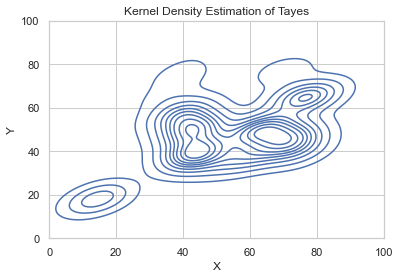

In [6]:
# Density Map Visualization
# kdeplot
sns.set(style='whitegrid')
sns.kdeplot(densityMap_df.Grid_Y-0.5, densityMap_df.Grid_X-0.5,
            clip=(0,100))
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0,100)
plt.ylim(0,100)
plt.title("Kernel Density Estimation of Tayes")
plt.savefig('KDE.png',dpi=1000)

/Users/michaelxu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


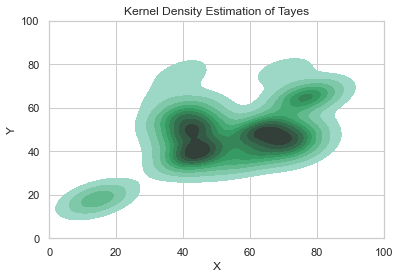

In [7]:
# kde_plot visualization
sns.kdeplot(densityMap_df.Grid_Y-0.5, densityMap_df.Grid_X-0.5,
            clip=(0,100), fill=True, cmap="BuGn_d")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0,100)
plt.ylim(0,100)
plt.title("Kernel Density Estimation of Tayes")
plt.savefig('KDE_fill.png',dpi=1000)

/Users/michaelxu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


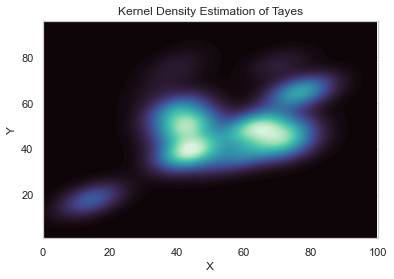

In [8]:
# kde_plot visualization
sns.kdeplot(densityMap_df.Grid_Y-0.5, densityMap_df.Grid_X-0.5,
           fill=True, thresh=0, levels=100, cmap="mako")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0,100)
plt.title("Kernel Density Estimation of Tayes")
plt.savefig('KDE_heat.png',dpi=1000)

In [9]:
Density2D_df = pd.DataFrame(np.zeros(shape=(100,100)))
for i in range(0,100):
    for j in range(0,100):
        val = density_df.loc[(density_df["Grid_X"]==i+1) & (density_df["Grid_Y"]==j+1),["Density"]]
        Density2D_df.iloc[i,j] = val.iloc[0,0]
# sns.heatmap(data = Density2D_df,cmap="RdBu_r")


/Users/michaelxu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


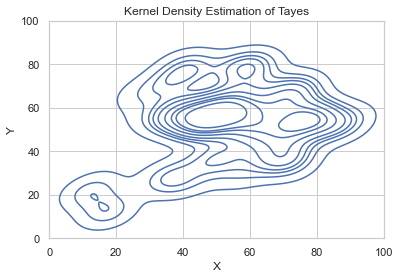

In [10]:
# visualization from samples.csv
sns.set(style='whitegrid')
samples_df = pd.read_csv("samples.csv")
sns.kdeplot(samples_df.X, samples_df.Y, clip=(0,100))
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0,100)
plt.ylim(0,100)
plt.title("Kernel Density Estimation of Tayes")
plt.savefig('KDE_revised.png',dpi=1000)

/Users/michaelxu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


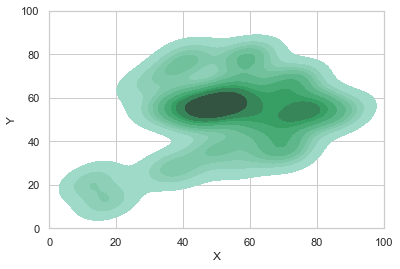

In [11]:
sns.set(style='whitegrid')
sns.kdeplot(samples_df.X, samples_df.Y, 
            shade=True, cmap="BuGn_d")
plt.xlim(0,100)
plt.ylim(0,100)
plt.savefig('KDE_fill_revised.png',dpi=1000)

/Users/michaelxu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


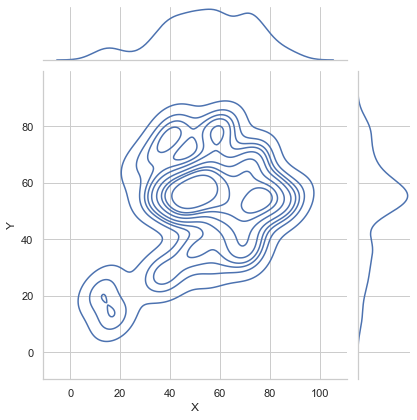

In [12]:
with sns.axes_style('whitegrid'):
    sns.jointplot('X','Y',samples_df, clip=(0,100), kind='kde')
plt.savefig('KDE_jointdensity.png',dpi=1000)    

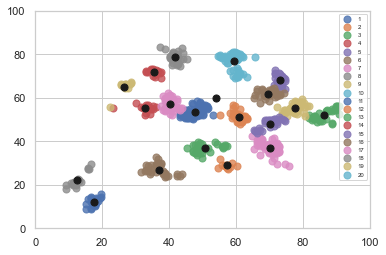

In [16]:
# K-means
kmeans = KMeans(n_clusters=20, init='k-means++', random_state=98)
label = kmeans.fit_predict(samples_df)

#Getting the Centroids
centroids = kmeans.cluster_centers_

#Getting unique labels
u_labels = np.unique(label)+1

for i in u_labels:
    plt.scatter(samples_df[label == i]["X"] , samples_df[label == i]["Y"],
               s=50, cmap='viridis',label = i, alpha=0.8)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 50, color = 'k')
plt.xlim(0,100)
plt.ylim(0,100)
plt.legend(loc=1,prop={'size':6})
plt.savefig('Kmeans.png',dpi=1000)

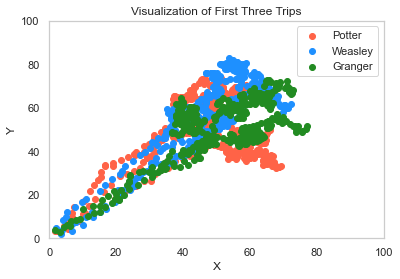

In [14]:
# extract "close" and "far" data frame
proj_df = pd.read_csv("data_proj_414.csv")
close_df = proj_df.loc[proj_df["Close"]>0,["X","Y","Close"]]
far_df = proj_df.loc[proj_df["Far"]>0,["X","Y","Far"]]
frames = [close_df, far_df]
both_df = pd.concat(frames)

# extract data frame of each person
Potter_df = proj_df.loc[(proj_df["Potter"]>0) & (proj_df["Trip"]<4),["X","Y"]]
Weasley_df = proj_df.loc[(proj_df["Weasley"]>0)& (proj_df["Trip"]<4),["X","Y"]]
Granger_df = proj_df.loc[(proj_df["Granger"]>0)& (proj_df["Trip"]<4),["X","Y"]]

plt.xlim(0,100)
plt.ylim(0,100)
plt.scatter(Potter_df["X"],Potter_df["Y"],color = "tomato",label="Potter")
plt.scatter(Weasley_df["X"],Weasley_df["Y"],color = "dodgerblue",label="Weasley")
plt.scatter(Granger_df["X"],Granger_df["Y"],color = "forestgreen",label="Granger")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(linestyle='-.')
plt.legend(loc='upper right')
plt.title("Visualization of First Three Trips")
plt.show()

1.0999999999999996 98.9 1.2999999999999998 90.7


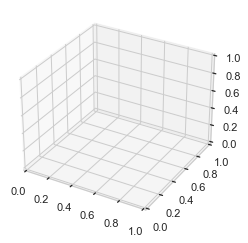

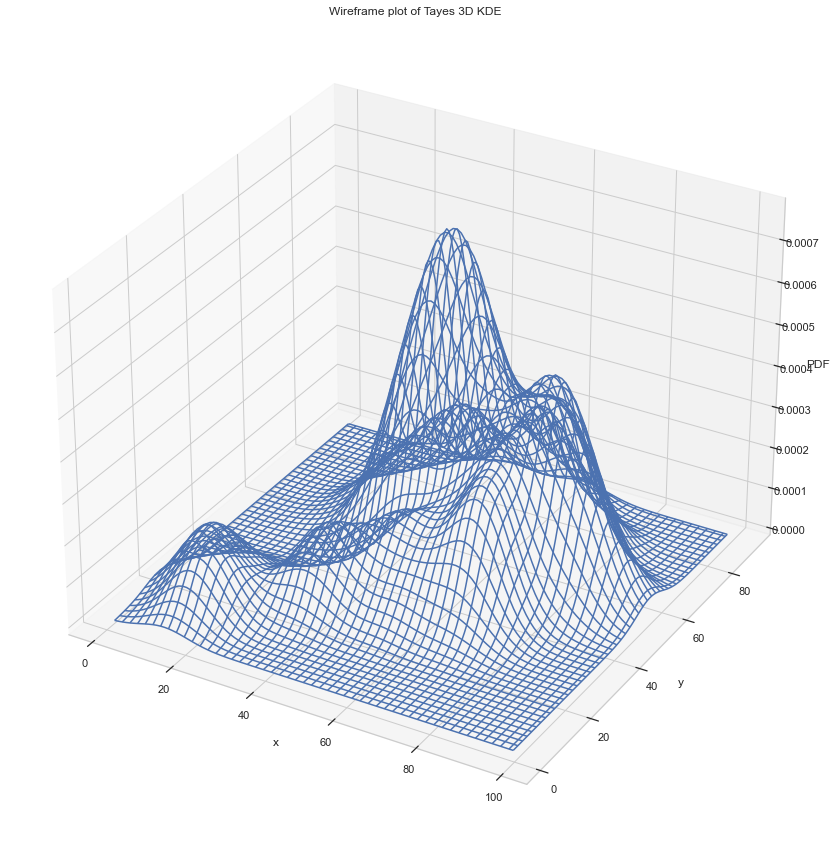

In [15]:
import scipy.stats as st
ax = plt.axes(projection='3d')
x = samples_df.X
y = samples_df.Y
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure(figsize=(18,15))
ax = plt.axes(projection='3d')
w = ax.plot_wireframe(xx, yy, f)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Wireframe plot of Tayes 3D KDE')
plt.savefig('Kmeans.png',dpi=1000)